# Install Pytorch, Torchvision

In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

     |████████████████████████████████| 831.4 MB 7.0 kB/s 
     |████████████████████████████████| 22.1 MB 1.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible.
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-cm7sev0c
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-cm7sev0c
     |████████████████████████████████| 596 kB 5.4 MB/s 
  Created 

'1.9.1+cu102'

# Install Detectron2

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 13355, done.
remote: Counting objects: 100% (856/856), done.
remote: Compressing objects: 100% (434/434), done.
remote: Total 13355 (delta 537), reused 677 (delta 417), pack-reused 12499
Receiving objects: 100% (13355/13355), 5.71 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (9497/9497), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 74 kB 2.0 MB/s 
     |████████████████████████████████| 145 kB 11.5 MB/s 
     |████████████████████████████████| 130 kB 44.9 MB/s 
     |████████████████████████████████| 743 kB 40.9 MB/s 
     |████████████████████████████████| 748 kB 35.4 MB/s 
     |████████████████████████████████| 112 kB 46.5 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=fc6fd77bf2bef1392fa24b08b8a8da3edcf591bdc036af309d818ecc85cfb041
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb

# Import

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train with COCO dataset

In [3]:
# Grant access to google drive.
# Run this cell, then you’ll see a link, click on that link, allow access
# Copy the code that pops up, paste it in the box, hit Enter

import os
from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder
# os.chdir('/content/gdrive/My Drive/Your Folder Name/Your sub Folder Name')
os.chdir('/content/gdrive/My Drive/detectron')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
coco_test  coco_train  detectron2_repo	output


Register the tools dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("tools", {}, "coco_train/labels.json", "coco_train/data")

In [5]:
tools_metadata = MetadataCatalog.get("tools")
dataset_dicts = DatasetCatalog.get("tools")

WARNING [10/21 11:36:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/21 11:36:28 d2.data.datasets.coco]: Loaded 4411 images in COCO format from coco_train/labels.json


In [6]:
register_coco_instances("test_tools", {}, "coco_test/labels.json", "coco_test/data")
test_tools_metadata = MetadataCatalog.get("test_tools")
test_dataset_dicts = DatasetCatalog.get("test_tools")

WARNING [10/21 11:36:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/21 11:36:42 d2.data.datasets.coco]: Loaded 1103 images in COCO format from coco_test/labels.json


Visualising annotations of random training set to verify imported dataset

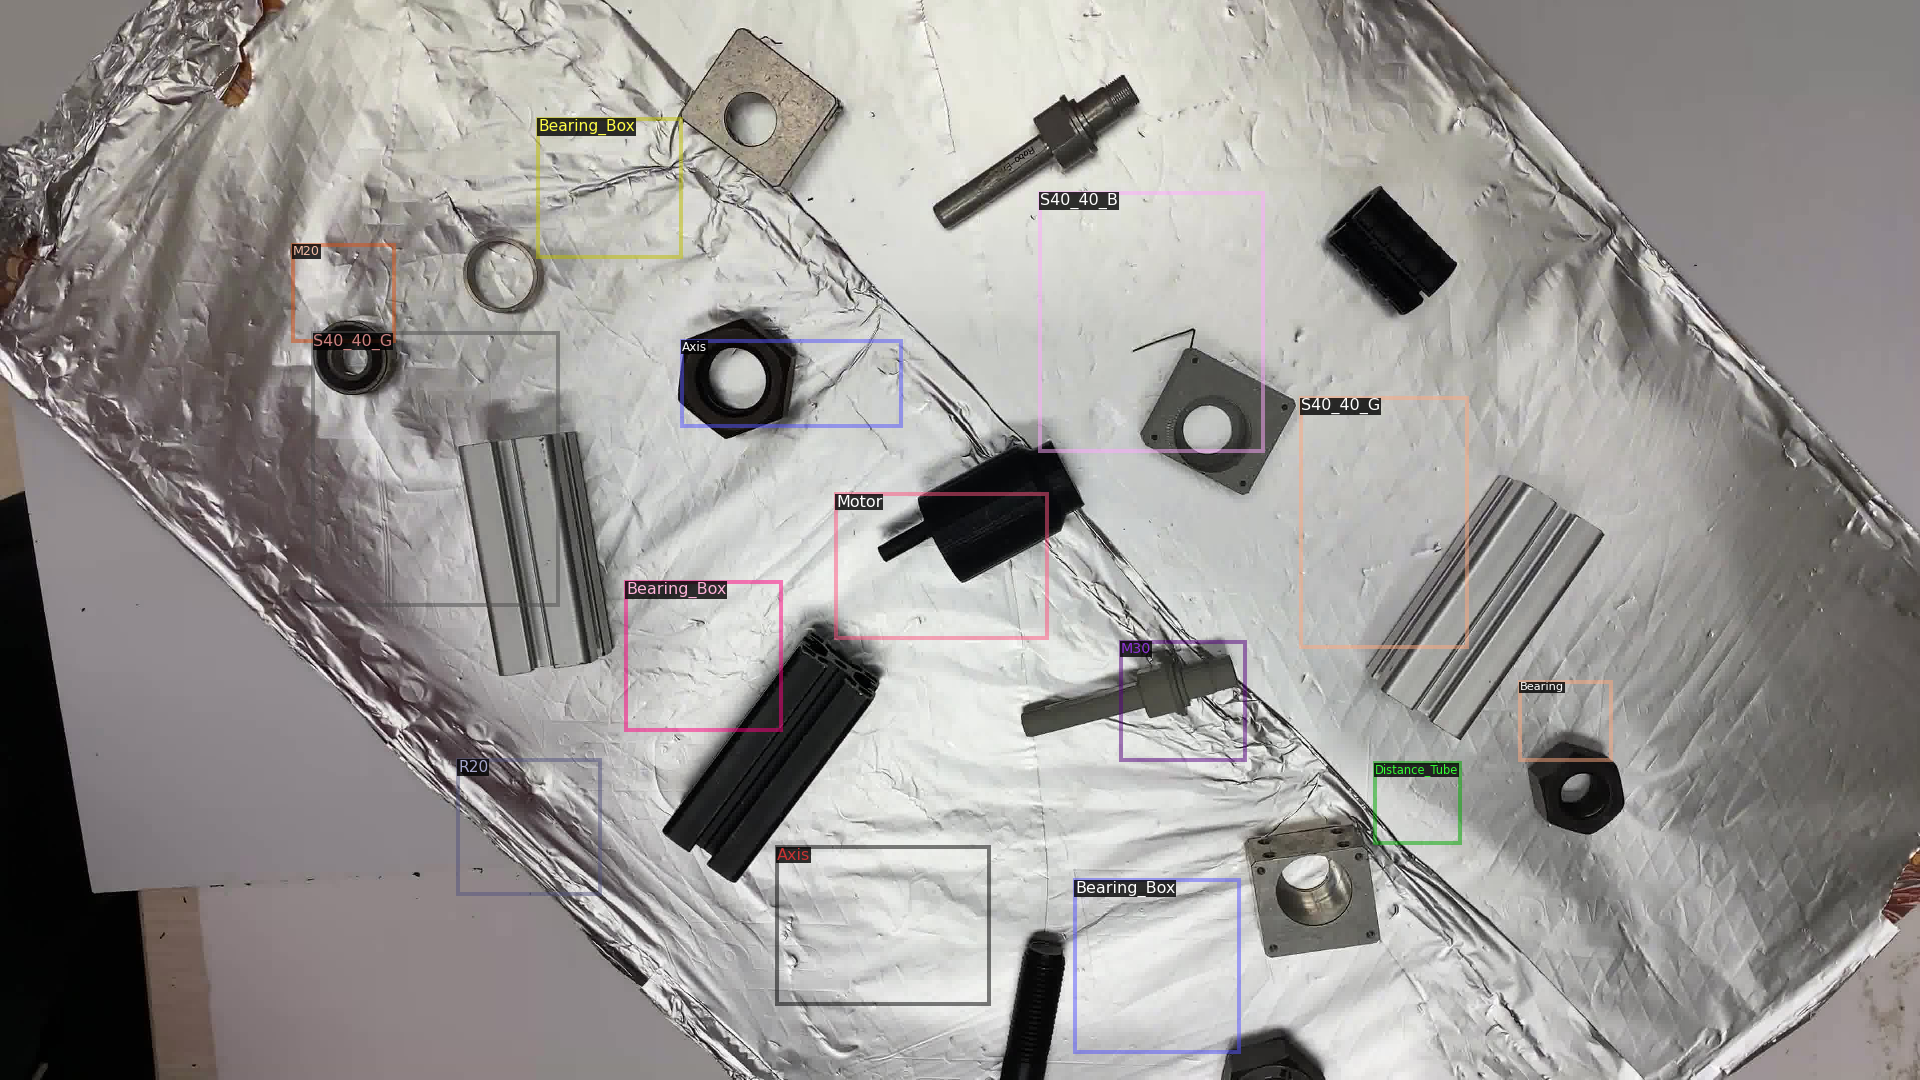

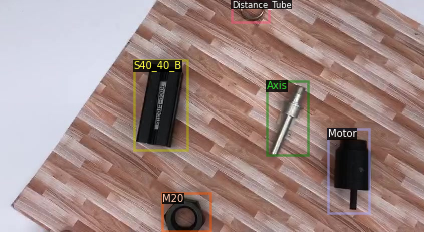

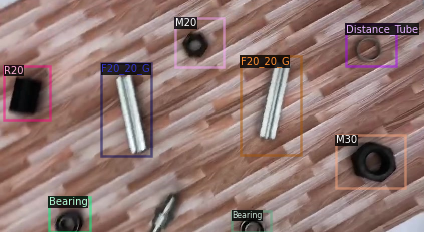

In [7]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=tools_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [8]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator 
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

Train model with coco pretrained faster rcnn.
Tune hyper parameters


In [10]:
!rm ./output/metrics.json

In [38]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("tools",)
#cfg.DATASETS.TEST = ()
cfg.DATASETS.TEST = ("test_tools",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 300
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
#cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14    # 1 more to include super category "Defect"
cfg.MODEL.RETINANET.NUM_CLASSES = 14    # 1 more to include super category "Defect"
#cfg.TEST.EVAL_PERIOD = 20

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
#trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

Loading config /content/detectron2_repo/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[10/21 12:12:35 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (126, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (126,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
head.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


[10/21 12:12:36 d2.engine.train_loop]: Starting training from iteration 0
[10/21 12:13:19 d2.utils.events]:  eta: 0:10:14  iter: 19  total_loss: 2.148  loss_cls: 1.627  loss_box_reg: 0.3943  time: 2.1149  data_time: 0.0298  lr: 0.0012854  max_mem: 5451M
[10/21 12:14:01 d2.utils.events]:  eta: 0:09:30  iter: 39  total_loss: 0.7646  loss_cls: 0.5726  loss_box_reg: 0.212  time: 2.1252  data_time: 0.0083  lr: 0.0026174  max_mem: 5451M
[10/21 12:14:43 d2.utils.events]:  eta: 0:08:45  iter: 59  total_loss: 0.5705  loss_cls: 0.347  loss_box_reg: 0.208  time: 2.1113  data_time: 0.0080  lr: 0.0039494  max_mem: 5451M
[10/21 12:15:26 d2.utils.events]:  eta: 0:08:00  iter: 79  total_loss: 0.5932  loss_cls: 0.3751  loss_box_reg: 0.1961  time: 2.1126  data_time: 0.0082  lr: 0.0052814  max_mem: 5451M
[10/21 12:16:08 d2.utils.events]:  eta: 0:07:17  iter: 99  total_loss: 0.4521  loss_cls: 0.2658  loss_box_reg: 0.1814  time: 2.1104  data_time: 0.0085  lr: 0.0066134  max_mem: 5451M
[10/21 12:16:51 d2.ut

In [49]:
import json
import matplotlib.pyplot as plt

experiment_folder = './output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

experiment_metrics

[{'data_time': 0.007249391000073047,
  'eta_seconds': 855.6339133999791,
  'iteration': 19,
  'loss_box_reg': 0.37486110627651215,
  'loss_cls': 0.8217037618160248,
  'lr': 0.0012854000000000001,
  'num_pos_anchors': 193.25,
  'time': 3.0558354049999252,
  'total_loss': 1.2589714527130127},
 {'data_time': 0.007782714499967369,
  'eta_seconds': 700.7202932599841,
  'iteration': 39,
  'loss_box_reg': 0.2120712250471115,
  'loss_cls': 0.3111855089664459,
  'lr': 0.0026174,
  'num_pos_anchors': 206.0,
  'time': 2.46722525749999,
  'total_loss': 0.5224653631448746},
 {'data_time': 0.007663415500019255,
  'eta_seconds': 594.9814137600151,
  'iteration': 59,
  'loss_box_reg': 0.17892707139253616,
  'loss_cls': 0.1974211260676384,
  'lr': 0.0039494,
  'num_pos_anchors': 218.5,
  'time': 2.4672630579999577,
  'total_loss': 0.3983168452978134},
 {'data_time': 0.007916572999988603,
  'eta_seconds': 543.5161419600036,
  'iteration': 79,
  'loss_box_reg': 0.1863170564174652,
  'loss_cls': 0.1721632

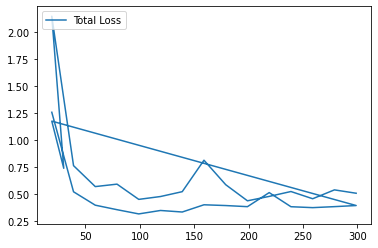

In [50]:
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
#plt.plot(
#    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
#    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
#plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.legend(['Total Loss'], loc='upper left')
plt.show()

# Load trained model

In [44]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model (Any confidence level that is >= 50% will show)
cfg.DATASETS.TEST = ("tools", )
predictor = DefaultPredictor(cfg)

# Testing

Then we test using testing dataset

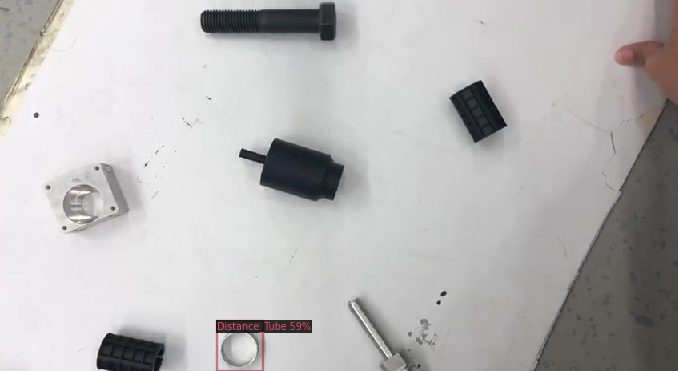

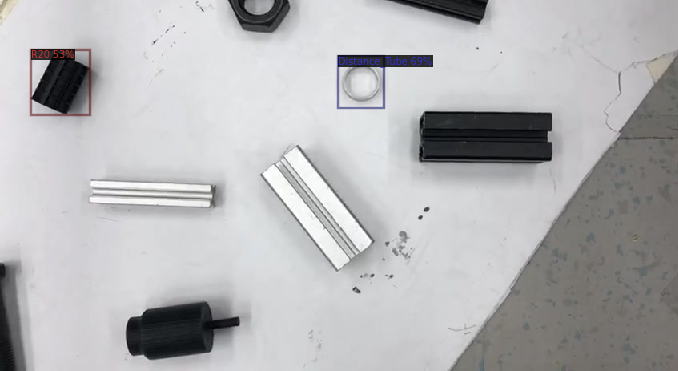

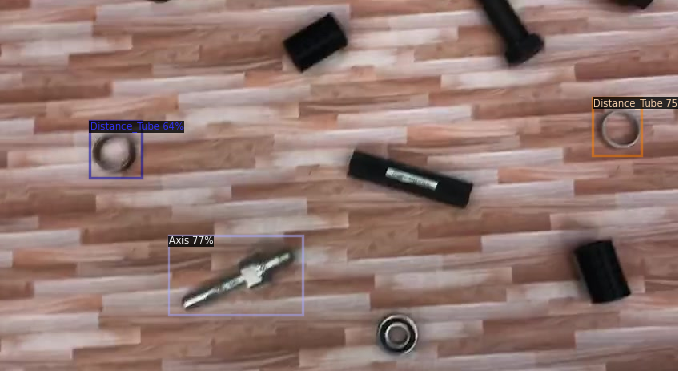

In [45]:
for d in random.sample(test_dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_tools_metadata, 
                   scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

## Benchmark inference speed

In [43]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.59,fps:1.70
